In [99]:
# Core
import re
import pandas as pd
import numpy as np
import pickle
import csv

import nltk, spacy, string
from pprint import pprint

pd.set_option("display.max_colwidth", -1)

## NLTK 
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
Pstemmer = nltk.stem.PorterStemmer()
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

import gensim
from gensim import corpora, models, similarities
from gensim.utils import lemmatize
from gensim.models.coherencemodel import CoherenceModel

# Sklearn
import sklearn.metrics 
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import chi2_contingency

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/allisonkelly/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allisonkelly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/allisonkelly/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/allisonkelly/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
dog_data_SF_19_full = pd.read_csv("Model_Data/dog_data_STL_ready.csv")

In [5]:
dog_data_SF_19_full = dog_data_SF_19_full.dropna(subset=['desc_full_clean'])

In [6]:
sum(pd.isnull(dog_data_SF_19_full["desc_full_clean"]))

0

### Extract pet names and city names to extract from text

In [7]:
len(dog_data_SF_19_full['name'].unique())

2810

In [8]:
names_split = [word.split(' ')[0].lower() for word in dog_data_SF_19_full['name'] ]
print(len(names_split))
names_unq = list(set(names_split))
print(len(names_unq))


3994
2241


In [9]:
len(dog_data_SF_19_full['contact.address.city'].unique())

75

In [10]:
city_split = [word.lower() for word in dog_data_SF_19_full['contact.address.city'] ]
print(len(city_split))
cities_unq = list(set(city_split))
print(len(cities_unq))

3994
73


### Prepare text for use in topic modeling: tokenize, lemmatize, stem

In [11]:
def lemmatization(text, postags=["ADJ"]):
    texts_out = [
        token.lemma_ if token.lemma_ not in ["-PRON-"] else ""
        for token in nlp(text)
        if token.pos_ in postags
    ]
    return texts_out

nlp = spacy.load("en", disable=["parser", "ner"])

In [12]:
dog_data_SF_19_full["desc_lemm_adj"] = dog_data_SF_19_full["desc_full_clean"].apply(
    lemmatization
)

In [13]:
other_words = names_unq + cities_unq

pd.DataFrame(other_words).to_csv("stop_words_full.csv", index=False)

In [14]:
swfull = stopwords.words("english") + names_unq + cities_unq

def stop_wrds(text_str):
    if len(text_str) != 0:
        return [word.lower() for word in text_str if word not in swfull]

In [15]:
dog_data_SF_19_full["desc_lemm_st"] = dog_data_SF_19_full["desc_lemm_adj"].apply(
    stop_wrds
)

In [16]:
def token_stem(text_str):
    if len(text_str) != 0:
        list_tok = [word for word in text_str if len(word) > 2]
        return [Pstemmer.stem(word) for word in list_tok]

In [17]:
dog_data_SF_19_full = dog_data_SF_19_full.dropna(subset=["desc_lemm_st"])

In [18]:
dog_data_SF_19_full["desc_lemm_adj"] = dog_data_SF_19_full["desc_lemm_st"].apply(
    token_stem
)

In [20]:
# dog_data_SF_19_full["desc_lemm_adj"].head(10)

In [21]:
adj_words = dog_data_SF_19_full["desc_lemm_adj"]

In [22]:
adj_words = adj_words[pd.isnull(adj_words) == False]

In [26]:
adj_words.shape

(3969,)

In [27]:
dictionary_descr_adj = corpora.Dictionary(adj_words)
corpus_descr_adj = [dictionary_descr_adj.doc2bow(text) for text in adj_words]

desc_adj_tfidf = models.TfidfModel(corpus_descr_adj)
corpus_adj_tfidf = desc_adj_tfidf[corpus_descr_adj]

In [28]:
### read in trained model

dict_lda = pickle.load(open("Exported_models/lda_dict_17_tps.sav", "rb"))
lda = pickle.load(open("Exported_models/lda_model_17_tps.sav", "rb"))


In [29]:
test_corp = dictionary_descr_adj.doc2bow(
    [
        "Outgoing",
        "Amazing",
        "energetic",
        "trainable",
        "Typical",
        "puppy",
        "Confident",
        "loyal",
        "Quiet",
        "delightful",
        "Wonderful",
        "affectionate",
        "nice",
        "Playful",
        "Calm",
        "Active",
        "Smart",
        "Strong",
        "secure",
        "Ideal",
        "Easy",
        "going",
    ]
)

In [41]:
test = pd.DataFrame(lda.get_document_topics(test_corp, minimum_probability=0.01))

In [42]:
test

,0,1
0,0,0.019608
1,1,0.019608
2,2,0.019608
3,3,0.019608
4,4,0.019608
5,5,0.019608
6,6,0.686274
7,7,0.019608
8,8,0.019608
9,9,0.019608


### Predict out, merge with all data and export for modeling

In [43]:
lda_adj_topics = lda.get_document_topics(corpus_adj_tfidf, minimum_probability=0.0)

In [44]:
list_top = pd.DataFrame(lda_adj_topics[0])[0]

In [45]:
list_top[3]

3

In [46]:
len([top for top in list_top if top in [0,2,3,4,6,7,8,9,10,11,12,13,16]])


13

In [47]:
adj_words_df =pd.DataFrame(adj_words)
adj_words_df['all_index'] = adj_words_df.index
adj_words_df = adj_words_df.reindex(range(0,21938))
adj_words_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21938 entries, 0 to 21937
Data columns (total 2 columns):
desc_lemm_adj    3969 non-null object
all_index        3969 non-null float64
dtypes: float64(1), object(1)
memory usage: 342.9+ KB


In [48]:
lda_topics_df  = pd.DataFrame(lda_adj_topics)

In [49]:
lda_topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3969 entries, 0 to 3968
Data columns (total 17 columns):
0     3969 non-null object
1     3969 non-null object
2     3969 non-null object
3     3969 non-null object
4     3969 non-null object
5     3969 non-null object
6     3969 non-null object
7     3969 non-null object
8     3969 non-null object
9     3969 non-null object
10    3969 non-null object
11    3969 non-null object
12    3969 non-null object
13    3969 non-null object
14    3969 non-null object
15    3969 non-null object
16    3969 non-null object
dtypes: object(17)
memory usage: 527.2+ KB


In [50]:
all_data_topics_df = pd.concat([adj_words_df, lda_topics_df], axis=1)

In [51]:
all_data_topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21938 entries, 0 to 21937
Data columns (total 19 columns):
desc_lemm_adj    3969 non-null object
all_index        3969 non-null float64
0                3969 non-null object
1                3969 non-null object
2                3969 non-null object
3                3969 non-null object
4                3969 non-null object
5                3969 non-null object
6                3969 non-null object
7                3969 non-null object
8                3969 non-null object
9                3969 non-null object
10               3969 non-null object
11               3969 non-null object
12               3969 non-null object
13               3969 non-null object
14               3969 non-null object
15               3969 non-null object
16               3969 non-null object
dtypes: float64(1), object(18)
memory usage: 3.2+ MB


In [52]:
all_data_topics_df.columns = [
    "desc_lemm_adj",
    "all_index",
    "topic_1",
    "topic_2",
    "topic_3",
    "topic_4",
    "topic_5",
    "topic_6",
    "topic_7",
    "topic_8",
    "topic_9",
    "topic_10",
    "topic_11",
    "topic_12",
    "topic_13",
    "topic_14",
    "topic_15",
    "topic_16",
    "topic_17"
]

In [53]:
dog_data_SF_w_tps = dog_data_SF_19_full.merge(
    all_data_topics_df,
    how="inner",
    left_index=True,
    right_on='all_index'
)

In [54]:
dog_data_SF_w_tps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3969 entries, 0 to 3994
Data columns (total 89 columns):
animal_id                     3969 non-null int64
age                           3969 non-null object
attributes.house_trained      3969 non-null int64
attributes.shots_current      3969 non-null int64
attributes.spayed_neutered    3969 non-null int64
attributes.special_needs      3969 non-null int64
breeds.mixed                  3969 non-null int64
breeds.primary                3969 non-null object
coat                          2602 non-null object
colors.primary                2266 non-null object
contact.address.city          3969 non-null object
environment.cats              1585 non-null object
environment.children          2441 non-null object
environment.dogs              3149 non-null object
gender                        3969 non-null object
name                          3969 non-null object
organization_id.1             3969 non-null object
size                          39

In [55]:
dog_data_SF_w_tps = dog_data_SF_w_tps.dropna(subset=["topic_1"])


In [56]:
sum(dog_data_SF_w_tps['desc_lemm_adj_x'] == dog_data_SF_w_tps['desc_lemm_adj_y'])

3943

### Validation

In [445]:
def convert_topic_val(topic_tpl, thres_topc=0.08):
    value = topic_tpl[1]
    if value > thres_topc:
        return 1
    else:
        return 0

In [446]:
for row in [
    "topic_1",
    "topic_2",
    "topic_3",
    "topic_4",
    "topic_5",
    "topic_6",
    "topic_7",
    "topic_8",
    "topic_9",
    "topic_10",
    "topic_11",
    "topic_12",
    "topic_13",
    "topic_14",
    "topic_15",
    "topic_16",
    "topic_17"
]:
    dog_data_SF_w_tps[row + "_val"] = dog_data_SF_w_tps[row].apply(convert_topic_val)

In [447]:
def convert_val(topic_tpl):
    return topic_tpl[1]

for row in [
    "topic_1",
    "topic_2",
    "topic_3",
    "topic_4",
    "topic_5",
    "topic_6",
    "topic_7",
    "topic_8",
    "topic_9",
    "topic_10",
    "topic_11",
    "topic_12",
    "topic_13",
    "topic_14",
    "topic_15",
    "topic_16",
    "topic_17"
]:
    dog_data_SF_w_tps[row + "_val_full"] = dog_data_SF_w_tps[row].apply(convert_val)

In [448]:
dog_data_SF_w_tps['topic_11_val_full'].describe()

count    3943.000000
mean     0.046134   
std      0.058522   
min      0.009184   
25%      0.014890   
50%      0.019884   
75%      0.056198   
max      0.642230   
Name: topic_11_val_full, dtype: float64

In [449]:
# dog_data_SF_w_tps['desc_full_clean'][dog_data_SF_w_tps['topic_11_val_full'] > 0.6]

In [450]:
dog_data_SF_w_tps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 0 to 3968
Columns: 123 entries, animal_id to topic_17_val_full
dtypes: float64(20), int64(62), object(41)
memory usage: 3.9+ MB


In [451]:
# dog_data_SF_w_tps.to_csv("Model_Data/dog_data_w_tpcs_3_17_tps.csv")

In [452]:
dog_data_SF_w_tps[[
    "topic_1_val",
    "topic_2_val",
    "topic_3_val",
    "topic_4_val",
    "topic_5_val",
    "topic_6_val",
    "topic_7_val",
    "topic_8_val",
    "topic_9_val",
    "topic_10_val",
    "topic_11_val",
    "topic_12_val",
    "topic_13_val",
    "topic_14_val",
    "topic_15_val",
    "topic_16_val",
    "topic_17_val"
]].describe()

,topic_1_val,topic_2_val,topic_3_val,topic_4_val,topic_5_val,topic_6_val,topic_7_val,topic_8_val,topic_9_val,topic_10_val,topic_11_val,topic_12_val,topic_13_val,topic_14_val,topic_15_val,topic_16_val,topic_17_val
count,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000,3943.000000
mean,0.354552,0.106518,0.242201,0.332742,0.275425,0.144814,0.068729,0.183109,0.196297,0.538169,0.164849,0.216079,0.227238,0.221405,0.283033,0.217347,0.319554
std,0.478438,0.308538,0.428470,0.471255,0.446785,0.351957,0.253025,0.386805,0.397246,0.498604,0.371091,0.411621,0.419101,0.415245,0.450530,0.412493,0.466363
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [453]:
# STL_validation_set = dog_data_SF_w_tps['desc_full_clean'].sample(frac=.1, random_state=99, axis=0)

In [454]:
# STL_validation_set.to_csv("STL_validation_set.csv")

In [455]:
### read in hand coded 

In [496]:
hand_codes  = pd.read_csv("/Users/allisonkelly/Documents/Insight/Petfinder_Project/STL_validation_set_200.csv")

In [490]:
hand_codes.iloc[:,2:] = hand_codes.iloc[:,2:].fillna(0)

In [491]:
hand_codes.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'desc_full_clean', 'topic_1_val', 'tp_hc_1',
       'topic_3_val', 'tp_hc_3', 'topic_4_val', 'tp_hc_4', 'topic_5_val',
       'tp_hc_5', 'topic_7_val', 'tp_hc_7', 'topic_8_val', 'tp_hc_8',
       'topic_9_val', 'tp_hc_9', 'topic_11_val', 'tp_hc_11', 'topic_12_val',
       'tp_hc_12', 'topic_13_val', 'tp_hc_13', 'topic_14_val', 'tp_hc_14',
       'topic_17_val', 'tp_hc_17'],
      dtype='object')

In [459]:
validation_cross = dog_data_SF_w_tps[['desc_full_clean',
    "topic_1_val",
    "topic_2_val",
    "topic_3_val",
    "topic_4_val",
    "topic_5_val",
    "topic_6_val",
    "topic_7_val",
    "topic_8_val",
    "topic_9_val",
    "topic_10_val",
    "topic_11_val",
    "topic_12_val",
    "topic_13_val",
    "topic_14_val",
    "topic_15_val",
    "topic_16_val",
    "topic_17_val"]
].merge(hand_codes, left_index=True, right_on="Unnamed: 0", how="right")

In [497]:
validation_cross[['desc_full_clean','Unnamed: 1']].head(5)

,desc_full_clean,Unnamed: 1
0,Female months old Lab Mix This dog will be local in OR WA at the location dates below Yes we adopt to Canada Residents you would need to drive to pick up dog September Friday am pm Petsmart NE th Ave Hillsboro OR September Saturday am pm Petsmart Guide Meridian Bellingham WA September Sunday am pm Petsmart Garden Way NE Unit Woodinville WA Adoption fee at the event will be which includes spay neutered microchip shots up to date and rabies certificate Email us for more info about how to adopt animalrescuekingdom Please note due to space on the transport vehicle not all dogs will attend the event if you are super interested in meeting a certain dog please email us,Female months old Lab Mix This dog will be local in OR WA at the location dates below Yes we adopt to Canada Residents you would need to drive to pick up dog September Friday am pm Petsmart NE th Ave Hillsboro OR September Saturday am pm Petsmart Guide Meridian Bellingham WA September Sunday am pm Petsmart Garden Way NE Unit Woodinville WA Adoption fee at the event will be which includes spay neutered microchip shots up to date and rabies certificate Email us for more info about how to adopt animalrescuekingdom Please note due to space on the transport vehicle not all dogs will attend the event if you are super interested in meeting a certain dog please email us
1,Daisy is a cutie pie that was rescued from a junk yard She is a chill girl and approx months old She is ready to find her forever home This dog will be local in OR WA at the location dates below July Saturday am pm Petsmart NE th Ave Hillsboro OR July Sunday am pm Petsmart Garden Way NE Unit Woodinville WA Yes we adopt to Canada Residents you would need to drive down to pickup the pup Yes we adopt to Canada Residents you would need to drive down to pickup the pup Adoption fee at the event will be which includes spay neutered microchip shots up to date and rabies certificate Please note due to space on the transport vehicle not all dogs will attend the event if you are super interested in meeting a certain dog please email us,Daisy is a cutie pie that was rescued from a junk yard She is a chill girl and approx months old She is ready to find her forever home This dog will be local in OR WA at the location dates below July Saturday am pm Petsmart NE th Ave Hillsboro OR July Sunday am pm Petsmart Garden Way NE Unit Woodinville WA Yes we adopt to Canada Residents you would need to drive down to pickup the pup Yes we adopt to Canada Residents you would need to drive down to pickup the pup Adoption fee at the event will be which includes spay neutered microchip shots up to date and rabies certificate Please note due to space on the transport vehicle not all dogs will attend the event if you are super interested in meeting a certain dog please email us
2,Meet Annabelle Our best guess is she a shih tzu Two to three years old As her foster mom I call her Annie for short Annie had quite the story She was dumped in a park please see before pic in the profile She was completely matted However she doesn t appear to hold grudges because she is super sweet She gets a long great with other respectful dogs She walks good on a leash She has not been cat tested but I don t see issues with cats and can test if needed Annie LOVES belly rubs She does this cute thing when you rub her belly where she holds your hands It s adorable Her new family must agree to belly rubs Annie is potty trained Annie will do good around respectful kids She will be a bit shy at first but if you talk to her nicely she will gain your trust and wag her tail nonstop If you are interested in hearing more on Annie please send an application to My Way Home and her foster mom will give you a call I am up to date on all of my vaccinations spayed and microchipped My adoption fee is If you would like to meet me please email for an application or visit our website,Meet Annabelle Our best guess is she a shih tzu Two to three years old 

In [498]:
validation_cross[
    [
        "topic_1_val",
        "topic_3_val",
        "topic_4_val",
        "topic_5_val",
        "topic_7_val",
        "topic_8_val",
        "topic_9_val",
        "topic_11_val",
        "topic_12_val",
        "topic_13_val",
        "topic_14_val",
        "topic_17_val",
    ]
].describe()

,topic_1_val,topic_3_val,topic_4_val,topic_5_val,topic_7_val,topic_8_val,topic_9_val,topic_11_val,topic_12_val,topic_13_val,topic_14_val,topic_17_val
count,198.000000,198.000000,198.000000,198.00000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,0.267677,0.237374,0.363636,0.29798,0.181818,0.186869,0.212121,0.126263,0.196970,0.262626,0.166667,0.363636
std,0.443870,0.426552,0.482265,0.45853,0.386672,0.390794,0.409847,0.332987,0.398717,0.441177,0.373623,0.482265
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [499]:
validation_cross[
    [
        "tp_hc_1",
        "tp_hc_3",
        "tp_hc_4",
        "tp_hc_5",
        "tp_hc_7",
        "tp_hc_8",
        "tp_hc_9",
        "tp_hc_11",
        "tp_hc_12",
        "tp_hc_13",
        "tp_hc_14",
        "tp_hc_17",
    ]
].describe()

,tp_hc_1,tp_hc_3,tp_hc_4,tp_hc_5,tp_hc_7,tp_hc_8,tp_hc_9,tp_hc_11,tp_hc_12,tp_hc_13,tp_hc_14,tp_hc_17
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,0.343434,0.181818,0.318182,0.227273,0.520202,0.136364,0.121212,0.085859,0.191919,0.171717,0.090909,0.232323
std,0.476059,0.386672,0.466951,0.420132,0.500858,0.344044,0.327201,0.280865,0.394808,0.378090,0.288209,0.423385
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [500]:
sklearn.metrics.multilabel_confusion_matrix(
    validation_cross[
        [
            "topic_1_val",
            "topic_3_val",
            "topic_4_val",
            "topic_5_val",
            "topic_7_val",
            "topic_8_val",
            "topic_9_val",
            "topic_11_val",
            "topic_12_val",
            "topic_13_val",
            "topic_14_val",
            "topic_17_val",
        ]
    ],
    validation_cross[
        [
            "tp_hc_1",
            "tp_hc_3",
            "tp_hc_4",
            "tp_hc_5",
            "tp_hc_7",
            "tp_hc_8",
            "tp_hc_9",
            "tp_hc_11",
            "tp_hc_12",
            "tp_hc_13",
            "tp_hc_14",
            "tp_hc_17",
        ]
    ],
)

array([[[120,  25],
        [ 10,  43]],

       [[148,   3],
        [ 14,  33]],

       [[120,   6],
        [ 15,  57]],

       [[135,   4],
        [ 18,  41]],

       [[ 76,  86],
        [ 19,  17]],

       [[160,   1],
        [ 11,  26]],

       [[155,   1],
        [ 19,  23]],

       [[173,   0],
        [  8,  17]],

       [[148,  11],
        [ 12,  27]],

       [[146,   0],
        [ 18,  34]],

       [[165,   0],
        [ 15,  18]],

       [[124,   2],
        [ 28,  44]]])

In [501]:
confusion_arrays = sklearn.metrics.multilabel_confusion_matrix(
    validation_cross[
        [
            "topic_1_val",
            "topic_3_val",
            "topic_4_val",
            "topic_5_val",
            "topic_7_val",
            "topic_8_val",
            "topic_9_val",
            "topic_11_val",
            "topic_12_val",
            "topic_13_val",
            "topic_14_val",
            "topic_17_val",
        ]
    ],
    validation_cross[
        [
            "tp_hc_1",
            "tp_hc_3",
            "tp_hc_4",
            "tp_hc_5",
            "tp_hc_7",
            "tp_hc_8",
            "tp_hc_9",
            "tp_hc_11",
            "tp_hc_12",
            "tp_hc_13",
            "tp_hc_14",
            "tp_hc_17",
        ]
    ],
)

In [502]:
len(confusion_arrays)

12

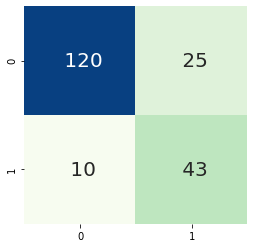

In [508]:
# tp_hc_1 active and smart 
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[0],
    annot_kws={"size": 20},
    annot=True,
    cmap="GnBu",
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)

plt.savefig('Demo_Figures/LDA_validation_tpc1.png')

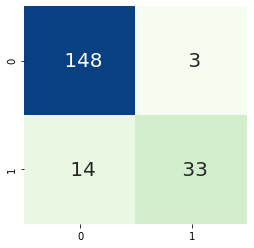

In [509]:
# "tp_hc_3",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[1],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)

plt.savefig("Demo_Figures/LDA_validation_tpc3.png")

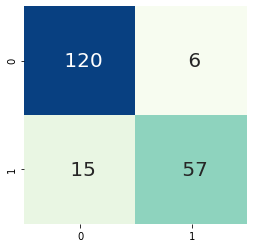

In [510]:
#           "tp_hc_4"
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[2],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)

plt.savefig("Demo_Figures/LDA_validation_tpc4.png")

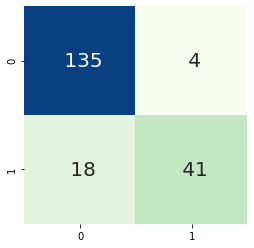

In [511]:
#            "tp_hc_5",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[3],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)

plt.savefig("Demo_Figures/LDA_validation_tpc5.png")

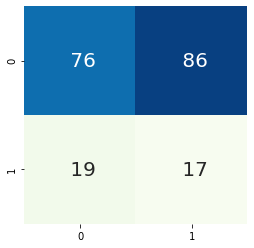

In [512]:
#            "tp_hc_7",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[4],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc7.png")

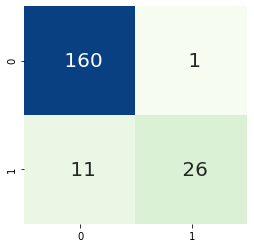

In [513]:
#            "tp_hc_8",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[5],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc8.png")

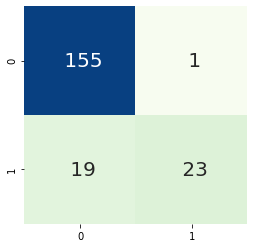

In [514]:
#          "tp_hc_9",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[6],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc9.png")

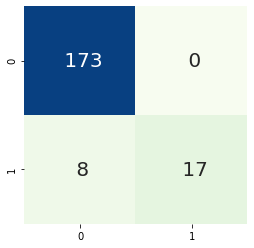

In [515]:
#            "tp_hc_11",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[7],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc11.png")

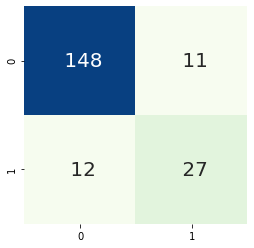

In [516]:
#            "tp_hc_12",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[8],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc12.png")

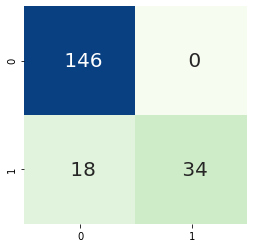

In [517]:
#            "tp_hc_13",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[9],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc13.png")

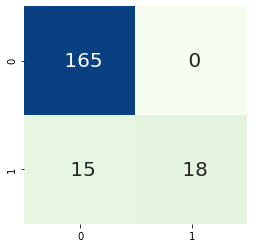

In [518]:
#            "tp_hc_14",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[10],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc14.png")

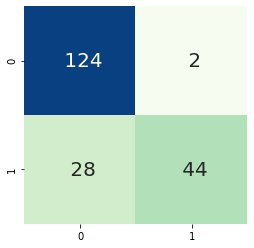

In [519]:
#            "tp_hc_17",
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    confusion_arrays[11],
    annot=True,
    cmap="GnBu",
    annot_kws={"size": 20},
    cbar=False,
    fmt=" ",
    ax=ax,
)
ax.set_ylim(2, 0)
plt.savefig("Demo_Figures/LDA_validation_tpc17.png")